In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

import cv2
import numpy as np
import os
import math
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
import time

from tensorflow import keras
from imutils import paths
from PIL import Image

from tensorflow.keras.layers import Dropout, MaxPooling2D, AveragePooling2D, Dense, Flatten, Input, Conv2D, add, Activation
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input)

from tensorflow.keras import applications
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential , Model , load_model
from tensorflow.keras.preprocessing.image import load_img , img_to_array , ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from PIL import Image
import matplotlib.pyplot as plt

import cv2
from imutils import paths
import numpy as np
import os
import math
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
import time

In [2]:
model = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = model
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [3]:
train_data_dir = './soil/train'  
val_data_dir = './soil/validation' 

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   fill_mode='nearest')
                            

val_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(  
         train_data_dir,
         target_size=(IMAGE_SIZE),  
         batch_size=BATCH_SIZE,
         shuffle=True) 

validation_dataset = val_datagen.flow_from_directory(  
         val_data_dir,  
         target_size=(IMAGE_SIZE),  
         batch_size=BATCH_SIZE,
         shuffle=True) 

Found 336 images belonging to 6 classes.
Found 225 images belonging to 6 classes.


In [6]:
num_examples= len(train_dataset.filenames)
num_classes= len(train_dataset.class_indices)

In [7]:
do_fine_tuning = False 

In [8]:
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape=IMAGE_SIZE + (3,),
    output_shape=[FV_SIZE],
    trainable=do_fine_tuning,
)

In [9]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential(
    [feature_extractor, tf.keras.layers.Dense(num_classes, activation="softmax")]
)

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
# @title (Optional) Unfreeze some layers
NUM_LAYERS = 17  # @param {type:"slider", min:1, max:50, step:1}

if do_fine_tuning:
    feature_extractor.trainable = True

    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

In [11]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [12]:
EPOCHS = 10

hist = model.fit(train_dataset,
                 epochs=EPOCHS,
                 validation_data=validation_dataset)
# hist = model.fit_generator(generator=train_dataset,
#                            steps_per_epoch=step_size_train,
#                            validation_data=validation_dataset,
#                            validation_steps=step_size_test,
#                            epochs=20)

Epoch 1/10
11/11 [==============================] - 12s 1s/step - loss: 1.6308 - accuracy: 0.3929 - val_loss: 1.2435 - val_accuracy: 0.5200
Epoch 2/10
11/11 [==============================] - 10s 943ms/step - loss: 0.8953 - accuracy: 0.7083 - val_loss: 0.7324 - val_accuracy: 0.7911
Epoch 3/10
11/11 [==============================] - 11s 959ms/step - loss: 0.6232 - accuracy: 0.8095 - val_loss: 0.5450 - val_accuracy: 0.8444
Epoch 4/10
11/11 [==============================] - 11s 961ms/step - loss: 0.4691 - accuracy: 0.8810 - val_loss: 0.4347 - val_accuracy: 0.9022
Epoch 5/10
11/11 [==============================] - 10s 949ms/step - loss: 0.3878 - accuracy: 0.8810 - val_loss: 0.3676 - val_accuracy: 0.9156
Epoch 6/10
11/11 [==============================] - 11s 956ms/step - loss: 0.3139 - accuracy: 0.9167 - val_loss: 0.3093 - val_accuracy: 0.9200
Epoch 7/10
11/11 [==============================] - 10s 940ms/step - loss: 0.2683 - accuracy: 0.9464 - val_loss: 0.2790 - val_accuracy: 0.9289
Ep

In [13]:
# Evaluasi model pada data validasi
evaluation = model.evaluate(validation_dataset)
accuracy = evaluation[1]  # Mengambil nilai akurasi dari hasil evaluasi

print("Akurasi Keseluruhan: ", int(accuracy * 100), '%')

8/8 [==============================] - 4s 487ms/step - loss: 0.1939 - accuracy: 0.9778
Akurasi Keseluruhan:  97 %


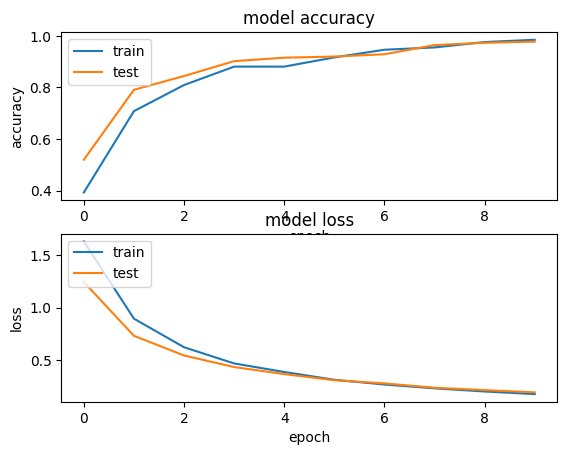

In [14]:
plt.figure(1)  
   
plt.subplot(211)  
plt.plot(hist.history['accuracy'])  
plt.plot(hist.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
plt.subplot(212)  
plt.plot(hist.history['loss'])  
plt.plot(hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [15]:
model.save('soil_classification_96.h5')

In [16]:
from tensorflow import lite

In [17]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [19]:
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

In [20]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [21]:
saved_model_dir = './TFLite'
tf.saved_model.save(model, saved_model_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
with open('soilmodel96.tflite', 'wb') as f:
 f.write(tflite_model)

INFO:tensorflow:Assets written to: ./TFLite\assets


INFO:tensorflow:Assets written to: ./TFLite\assets
